# Modeling and Simulation in Python

Starter code for the orbit example

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [95]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [96]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [97]:
# And an initial condition (with SI units)

r_0 = 4436.82e9 * m
v_0 = -6100 * m/s

init = State(x = r_0,
             y = 0 * m,
             vx = 0 * m / s,
             vy = 0 * m / s)

,values
x,4436820000000.0 meter
y,0 meter
vx,0.0 meter / second
vy,0.0 meter / second


In [98]:
# Making a system object

r_pluto = 1187000 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_pluto,
                m2=0.01303e24 * kg,
                t_0=0 * s,
                t_end=7820000000 * s)

,values
init,x 4436820000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,696695000.0 meter
m2,1.303e+22 kilogram
t_0,0 second
t_end,7820000000 second


In [99]:
# This function computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy = state
    unpack(system)
    r = Vector(x, y)
    v = Vector(vx, vy)
 
    force_mag = G * m1 * m2 / r.mag**2
    force = r.hat() * force_mag 
   # force = Vector(G*m1*m2/x**2, G*m1*m2/y**2)
    return force

In [100]:
universal_gravitation(init, system)

<Quantity([8.78661872e+16 0.00000000e+00], 'newton')>

In [101]:
# The slope function

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)    

    force_x, force_y = universal_gravitation(state, system)
    dxdt = vx
    dydt = vy
    dvxdt = -force_x / m2
    dvydt = -force_y / m2
    
    return dxdt, dydt, dvxdt, dvydt

In [102]:
# Testing the slope function

slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(-6.743375839653671e-06, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [103]:
# Event function that stops the simulation upon collision

def event_func(state, t, system):
    x, y, vx, vy = state
    position = Vector(x,y)
    return position.mag - system.r_final

In [104]:
# Testing the event function

events = event_func(init, 0, system)

<Quantity(4436123305000.0, 'meter')>

In [105]:
# Running the simulation

results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[900954942.142702]]
nfev,296
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [106]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(900954942.142702, 'second')>

In [107]:
# ... expressed in units we understand

t_final.to(UNITS.day)

<Quantity(10427.719237762753, 'day')>

In [108]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)

In [109]:
# Scaling the time steps to days

results.index /= 60 * 60 * 24

In [110]:
# Scaling the distance to million km

r = sqrt(results.y**2+results.x**2) / 1e9 

0.000000        4436.820000
52.138596       4436.751578
104.277192      4436.546308
156.415789      4436.204177
208.554385      4435.725164
260.692981      4435.109239
312.831577      4434.356365
364.970173      4433.466494
417.108770      4432.439564
469.247366      4431.275388
521.385962      4429.973882
573.524558      4428.535003
625.663154      4426.958693
677.801750      4425.244886
729.940347      4423.393503
782.078943      4421.404454
834.217539      4419.277639
886.356135      4417.012945
938.494731      4414.610249
990.633328      4412.069416
1042.771924     4409.390299
1094.910520     4406.572742
1147.049116     4403.616575
1199.187712     4400.521620
1251.326309     4397.287683
1303.464905     4393.914564
1355.603501     4390.402048
1407.742097     4386.749911
1459.880693     4382.957916
1512.019289     4379.025815
                   ...     
8915.699948     1947.216394
8967.838544     1907.403981
9019.977141     1866.794968
9072.115737     1825.385296
9124.254333     1783

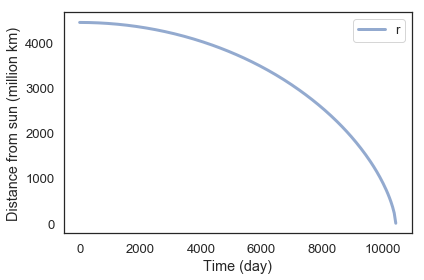

In [111]:
# And plotting

plot(r, label='r')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

In [112]:
# Now, we change our initial velocity to match the real orbit 
# of the Earth, so that it actually orbits and doesn't fall

init = State(x = r_0,
             y = 0 * m,
             vx = 0 * m / s,
             vy = v_0)

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_pluto,
                m2=0.01303e24 * kg,
                t_0=0 * s,
                t_end=7820000000 * s)

,values
init,x 4436820000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,696695000.0 meter
m2,1.303e+22 kilogram
t_0,0 second
t_end,7820000000 second


In [113]:
#And test again!

results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[]]
nfev,158
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [114]:
#So our final time should be a full year, which is how many seconds we started with!

t_final = get_last_label(results) * s

<Quantity(7820000000.0, 'second')>

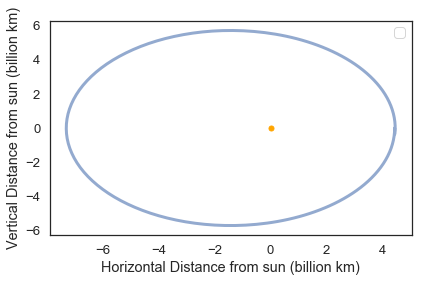

In [120]:
#This function makes the plot smoother by evaluating results more per amount of time
ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, method='RK23', t_eval=ts)

#Scaled to days!
results.index /= 60 * 60 * 24

#And to billions of km!
x = results.x / 1e12;
y = results.y /1e12;
plot(x, y)
plt.plot(0, 0, marker='o', markersize=5, color="orange")

#Plotted :)
decorate(xlabel='Horizontal Distance from sun (billion km)',
         ylabel='Vertical Distance from sun (billion km)')